# Delta Omicron multidms data fit

In [14]:
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr

from timeit import default_timer as timer
%matplotlib inline

import sys
sys.path.append("..")
from multidms.utils import create_homolog_modeling_data, initialize_model_params
from multidms.model import ϕ, g, prox, cost_smooth

Our primary goal is to get a single dataframe that contains all homolog variants encoded with sequencial sites wrt the wt seqences which have been aligned with no gaps - as well as their functional scores. This can then be converted into our model fitting data.

We'll start by collecting all the data for each homolog into a single dataframe containing all experiments
along with a column holding a nested dataframe for all the associated functional scores.

Additionally, we make a dictionary for the homolog wildtype sequences, and a df for the site maps of both sequences

In [15]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel])
    
    # WT Protein sequence
    with open(f"../results/{homolog}/protein.fasta", "r") as seq_file:
        header = seq_file.readline()
        wt_seqs[homolog] = seq_file.readline().strip()

    # Sites
    sites[homolog] = (
        pd.read_csv(f"../results/{homolog}/site_numbering_map.csv")
        .rename({"sequential_site":f"{homolog}_site", "sequential_wt":f"{homolog}_wt"})
        .set_index(["reference_site"])
    )

In [16]:
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,homolog
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,Delta
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,Delta
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,Delta
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,Delta
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,Delta
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,Delta
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,Delta
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,Delta
0,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,Omicron_BA.1
1,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,Omicron_BA.1


In [17]:
wt_seqs

{'Delta': 'MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDVYYHKNNKSWMESGVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQNVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEV

In [18]:
sites

{'Delta':                 sequential_site sequential_wt reference_wt
 reference_site                                            
 1                             1             M            M
 2                             2             F            F
 3                             3             V            V
 4                             4             F            F
 5                             5             L            L
 ...                         ...           ...          ...
 1249                       1247             S            S
 1250                       1248             C            C
 1251                       1249             G            G
 1252                       1250             S            S
 1253                       1251             *            C
 
 [1251 rows x 3 columns],
 'Omicron_BA.1':                 sequential_site sequential_wt reference_wt
 reference_site                                            
 1                             1             M 

In [19]:
set.symmetric_difference(
    set(sites["Delta"].reset_index()["reference_site"].values.astype(str)), 
    set(sites["Omicron_BA.1"].reset_index()["reference_site"].values.astype(str))
)

{'143', '144', '145', '157', '158', '211', '214a', '214b', '214c', '69', '70'}

In [20]:
homolog_column = "homolog"
reference_homolog = "Delta"
subs_col = "aa_substitutions_reference"
func_score_col = "func_score"
library = 'Lib-3'
subset_data = 500
maxiter = 200
clip_y = None
fig_saveas_prefix = f"{library}-{func_score_col}-ref-{reference_homolog}-subset-{subset_data}-iter-{maxiter}"

In [21]:
lib1_rep1_fs_sel = func_score_data.query(f"library == '{library}' & replicate == 1")
lib1_rep1_fs_sel

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,homolog
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,Delta
3,2022-06-22_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1,Lib-3_2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-3_2022-06-22_thaw-...,library pre_samp...,Omicron_BA.1


In [24]:
func_score_df = pd.DataFrame()
for idx, row in lib1_rep1_fs_sel.iterrows():
    exp_func_score_df = row.func_sel_scores_df.assign(homolog=row.homolog)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = [idx for idx, row in func_score_df.iterrows() if "-" in row.aa_substitutions_reference]
func_score_df.drop(gapped_sub_vars, inplace=True)
if subset_data:
    func_score_df = func_score_df.sample(n=subset_data, random_state=23)

In [25]:
(X, y), df, all_subs, site_map = create_homolog_modeling_data(
                            func_score_df, 
                            homolog_column,
                            reference_homolog,
                            subs_col,
                            func_score_col
                        )

Found 371 site(s) lacking data in at least one homolog.
323 of the 500 variants were removed because they had mutations at the above sites, leaving 177 variants.


100%|███████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 599.73it/s]


In [26]:
# for h, hy in y.items():
#     y[h] = y[h].clip(-5, 2.5)
#     print(y[h].min(), y[h].max())

In [29]:
# Initialize the range and minimum of the sigmoid
# from the global epistasis function using the 5th
# and 95th percentile values from the raw data
sig_upper = func_score_df.sample(n=min(5000, len(func_score_df)), random_state=23)[func_score_col].quantile(0.95)
sig_lower = func_score_df.sample(n=min(5000, len(func_score_df)), random_state=23)[func_score_col].quantile(0.05)
sig_range = sig_upper - sig_lower

# Initialize all params
params = initialize_model_params(
    func_score_df.homolog.unique(), 
    n_beta_shift_params=X[reference_homolog].shape[1],
    include_alpha=True,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)

In [30]:
print(f"\nPre-Optimization")
print(f"----------------")
print(f"cost = {cost_smooth(params, (X, y), λ_ridge=0):.2e}")


Pre-Optimization
----------------
cost = 2.38e+00


In [31]:
tol = 1e-6
maxiter = 15000
start = timer()

solver = ProximalGradient(cost_smooth, prox, tol=tol, maxiter=maxiter)
params, state = solver.run(
    params, 
    hyperparams_prox = dict(
        clip_stretch=0.0, 
        lock_params= {
            f"S_{reference_homolog}" : jnp.zeros(len(params['β'])),
            f"C_{reference_homolog}" : jnp.zeros(shape=(1,)),
#             f"C_Omicron_BA.1" : jnp.zeros(shape=(1,))
        }
    ),
    data=(X, y),
    λ_ridge=1e-5
)
end = timer()

print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
print(f"cost = {cost_smooth(params, (X, y)):.2e}")
print(f"Wall time for fit: {end - start}")


Post-Optimization
-----------------
Full model optimization: 15000 iterations
error = 9.67e-04
cost = 2.06e-01
Wall time for fit: 21.9630705867894


In [32]:
for param in ["β", f"S_Delta", "S_Omicron_BA.1"]:
    print(f"\nFit {param} distribution\n===============")
    arr = onp.array(params[param])
    mean = onp.mean(arr)
    median = onp.median(arr)
     
    # measures of dispersion
    min = onp.amin(arr)
    max = onp.amax(arr)
    range = onp.ptp(arr)
    variance = onp.var(arr)
    sd = onp.std(arr)
     
    print("Descriptive analysis")
    print("Measures of Central Tendency")
    print(f"Mean = {mean:.2e}")
    print(f"Median = {median:.2e}")
    print("Measures of Dispersion")
    print(f"Minimum = {min:.2e}")
    print(f"Maximum = {max:.2e}")
    print(f"Range = {range:.2e}")
    print(f"Variance = {variance:.2e}")
    print(f"Standard Deviation = {sd:.2e}")

print(f"\nFit Sigmoid Parameters, α\n================")
for param, value in params['α'].items():
    print(f"{param}: {value}") 

df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_{func_score_col}"] = onp.nan

print(f"\nRunning Predictions")
print(f"-------------------")
for homolog, hdf in df.groupby("homolog"):
    h_params = {"β":params["β"], "S":params[f"S_{homolog}"], "C":params[f"C_{homolog}"]}
    z_h = ϕ(h_params, X[homolog])
    print(z_h.shape)
    print(hdf.index.shape)
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h
    y_h_pred = g(params["α"], z_h)
    df.loc[hdf.index, f"predicted_{func_score_col}"] = y_h_pred

print(f"Done")


Fit β distribution
Descriptive analysis
Measures of Central Tendency
Mean = -1.87e-01
Median = -8.54e-02
Measures of Dispersion
Minimum = -7.81e+00
Maximum = 5.53e+00
Range = 1.33e+01
Variance = 1.77e+00
Standard Deviation = 1.33e+00

Fit S_Delta distribution
Descriptive analysis
Measures of Central Tendency
Mean = 0.00e+00
Median = 0.00e+00
Measures of Dispersion
Minimum = 0.00e+00
Maximum = 0.00e+00
Range = 0.00e+00
Variance = 0.00e+00
Standard Deviation = 0.00e+00

Fit S_Omicron_BA.1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = 7.25e-04
Median = 0.00e+00
Measures of Dispersion
Minimum = -2.03e-01
Maximum = 7.37e-01
Range = 9.40e-01
Variance = 5.71e-03
Standard Deviation = 7.56e-02

Fit Sigmoid Parameters, α
ge_bias: [-8.09598373]
ge_scale: [11.38228522]
latent_bias: [0.73815199]

Running Predictions
-------------------
(35,)
(35,)
(142,)
(142,)
Done


<AxesSubplot:ylabel='Count'>

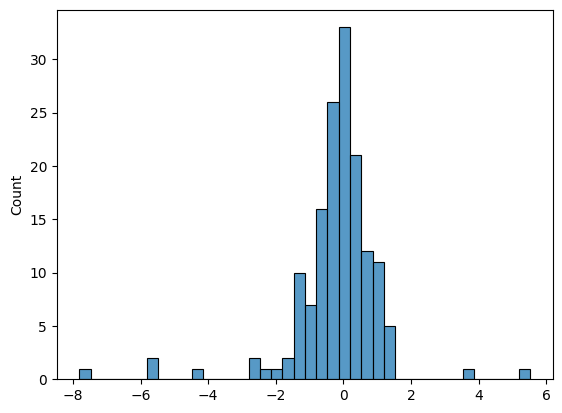

In [33]:
sns.histplot(params["β"])

<AxesSubplot:ylabel='Count'>

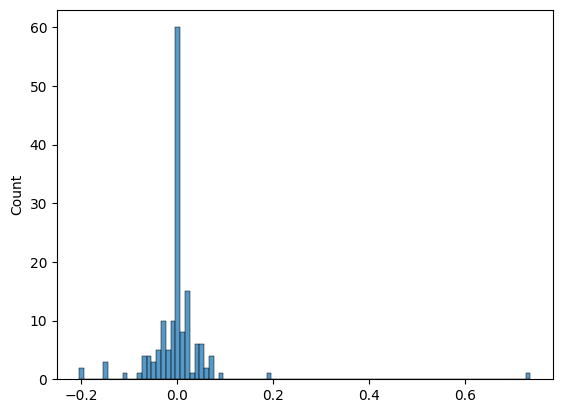

In [34]:
sns.histplot(params["S_Omicron_BA.1"])

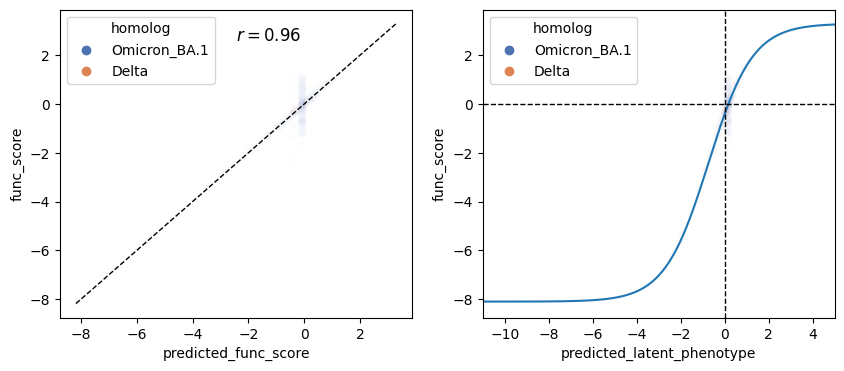

In [35]:
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
# df = df.sample(frac=1)
sns.scatterplot(
    data=df, x=f"predicted_{func_score_col}",
    y=func_score_col,
    hue="homolog",
    alpha=0.01, palette="deep", ax=ax[0],
    legend=True
)

lb = df[[func_score_col, f"predicted_{func_score_col}"]].min().min()
ub = df[[func_score_col, f"predicted_{func_score_col}"]].max().max()

ax[0].plot([lb, ub], [lb, ub], "k--", lw=1)
r = pearsonr(df[func_score_col], df[f'predicted_{func_score_col}'])[0]
ax[0].annotate(f"$r = {r:.2f}$", (.5, .9), xycoords="axes fraction", fontsize=12)

# shape 
sns.scatterplot(
    data=df, x="predicted_latent_phenotype",
    y=func_score_col,
    hue="homolog",
    alpha=0.01, palette="deep",
    legend=True, ax=ax[1]
)

ϕ_grid = onp.linspace(
    1.1 * df.predicted_latent_phenotype.min(),
    1.1 * df.predicted_latent_phenotype.max(),
    num=1000
)
shape = (ϕ_grid, g(params["α"], ϕ_grid))
ax[1].plot(*shape)
#ax[1].set_ylim(-11, 1)
ax[1].set_xlim(-11, 5)
plt.axhline(0, color="k", ls="--", lw=1)
plt.axvline(0, color="k", ls="--", lw=1)
fig.savefig(f"{fig_saveas_prefix}-scatter.png")
plt.show()

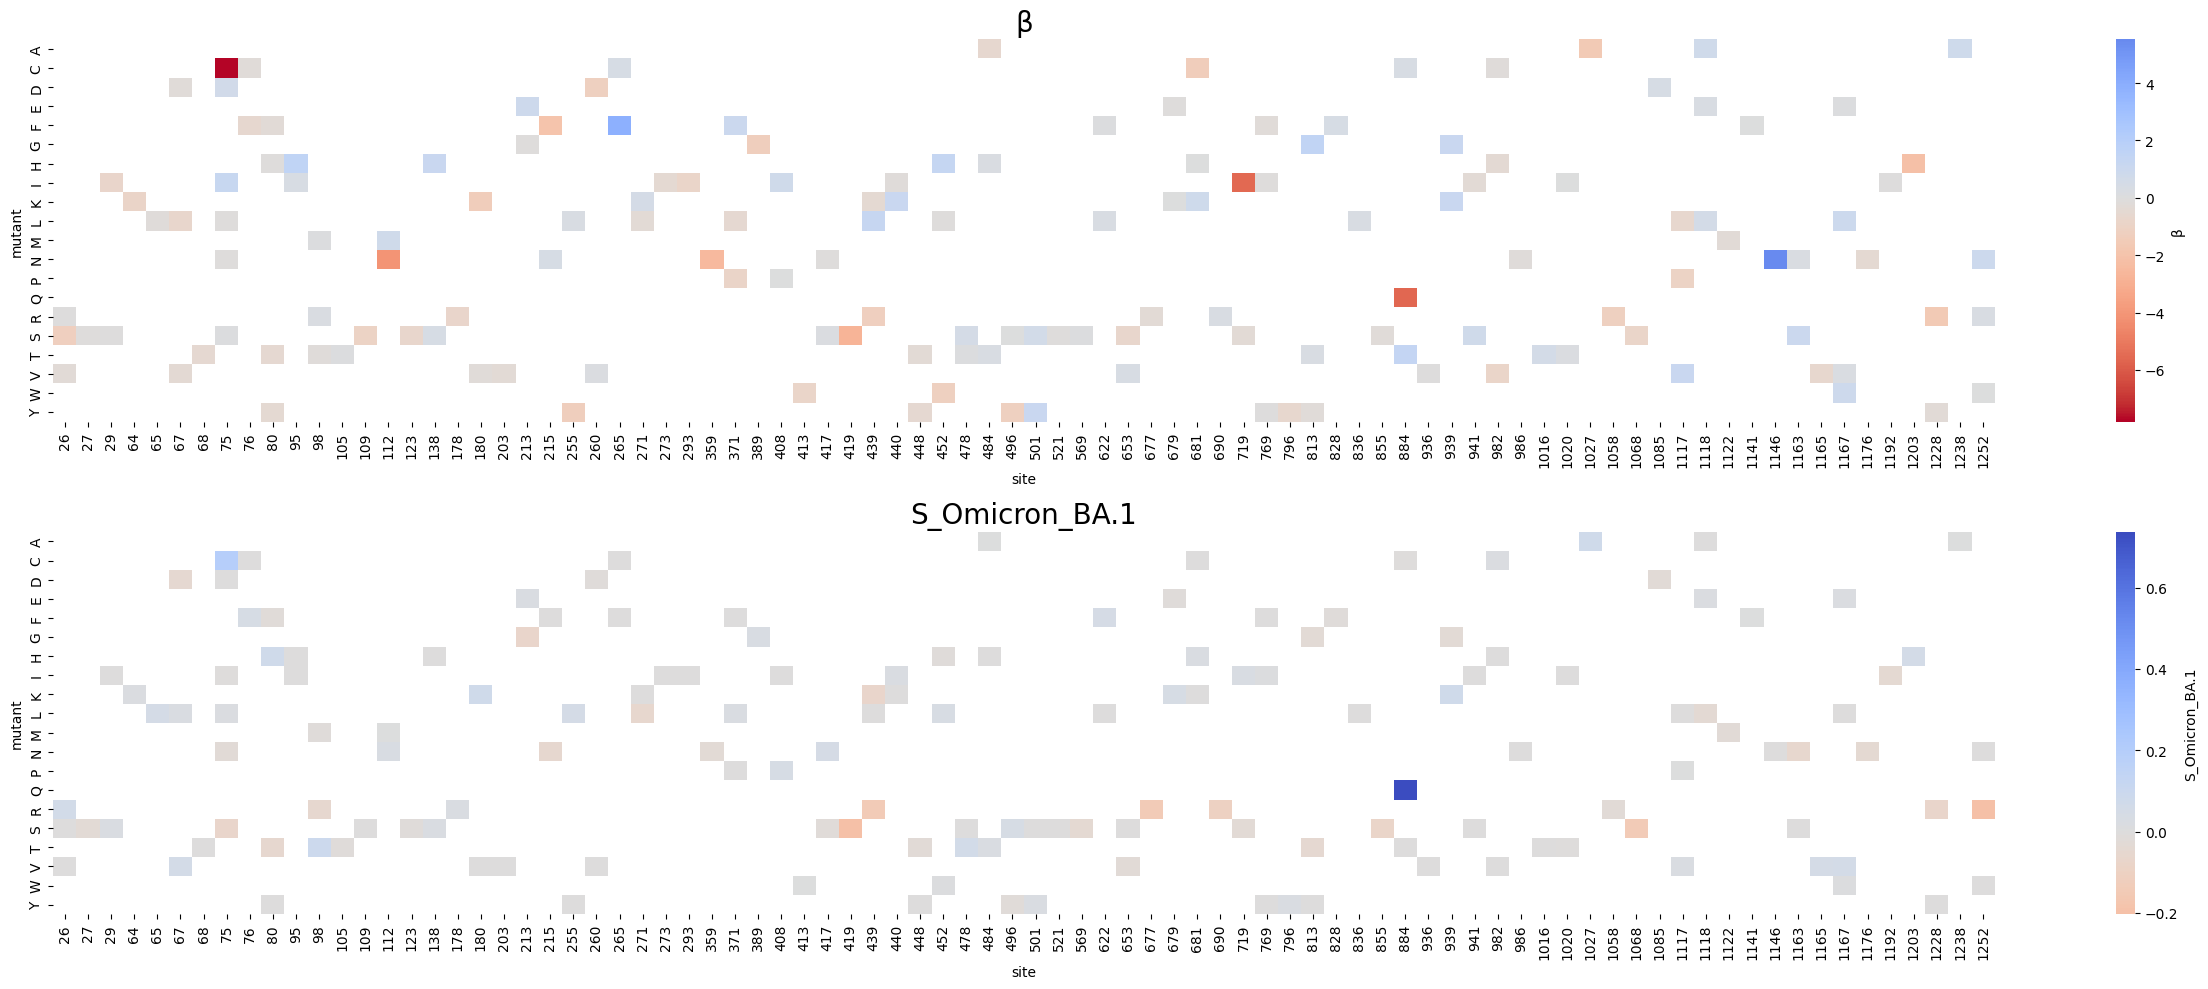

In [36]:
%matplotlib inline

fig, ax = plt.subplots(2, figsize=(25, 10))

# non_identical_sites = [
#     i for i, row in site_map.iterrows()
#     if row["Delta"] != row["Omicron_BA.1"]
# ]

def split_sub(sub_string):
    """String match the wt, site, and sub aa
    in a given string denoting a single substitution"""

    pattern = r'(?P<aawt>[A-Z\*])(?P<site>[\d\w]+)(?P<aamut>[A-Z\*])'
    match = re.search(pattern, sub_string)
    assert match != None, sub_string
    return match.group('aawt'), match.group('site'), match.group('aamut')

for i, param in enumerate(["β", "S_Omicron_BA.1"]):
    rows = []
    for mutation, p in zip(all_subs, params[param]):
        wt, site, mut = split_sub(mutation)
        rows.append([int(site), wt, mut, float(p)])
        
    mutation_effects = pd.DataFrame(
        rows,
        columns=("site", "wildtype", "mutant", param)
    ).pivot(
        index="mutant",
        columns="site", values=param
    )#.iloc[:, :500]
    
    sns.heatmap(
        mutation_effects, 
        mask=mutation_effects.isnull(),
        cmap="coolwarm_r",
        center=0,
        cbar_kws={"label": param},
        ax=ax[i]
    )
    ax[i].set_title(f"{param}", size=20)

    
plt.tight_layout()
fig.savefig(f"{fig_saveas_prefix}-heatmap.png")
plt.show()